In [71]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

In [72]:
import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils
data = pd.read_csv("../Data/hk_database_prueba.csv")
data.head(5)

,id,cx_curp,df_nacimiento,cs_sexo,first_cx,last_cx,count_cx_w,years_cx,window,x_start,...,I15,I159,I139,I131,I130,I11,I151,I158,I13,I132
0,#EHA6911199IMKERC1-1,#EHA6911199IMKERC1,19/11/1969,F,16/04/2018,06/10/2020,24.0,3,1,16/04/2018,...,0,0,0,0,0,0,0,0,0,0
1,#EHE671124ISYRCRC1-1,#EHE671124ISYRCRC1,24/11/1967,F,04/04/2017,11/12/2019,1.0,3,1,04/04/2017,...,0,0,0,0,0,0,0,0,0,0
2,AAAA2201010EDBBRC1-1,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,29.0,7,1,18/01/2005,...,0,0,0,0,0,0,0,0,0,0
3,AAAA2201010EDBBRC1-2,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,27.0,7,2,18/01/2006,...,0,0,0,0,0,0,0,0,0,0
4,AAAA2201010EDBBRC1-3,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,24.0,7,3,18/01/2007,...,0,0,0,0,0,0,0,0,0,0


In [73]:
data['first_cx']= pd.to_datetime(data['first_cx'])
data['last_cx']= pd.to_datetime(data['last_cx'])
data['df_nacimiento']= pd.to_datetime(data['df_nacimiento'])

data['edad'] = np.nan
for i in range(len(data['cx_curp'])): 
    if pd.isna(data['df_nacimiento'][i]):
        data['edad'][i] = np.nan        
    else: 
        data['edad'][i] = (int(data['first_cx'][i].year-data['df_nacimiento'][i].year)+\
                        int(data['last_cx'][i].year-data['df_nacimiento'][i].year))/2
        
data["edad_range"] = np.nan
data.loc[(data['edad'] <  11), 'edad_range'] = 1#'hasta 10 años'
data.loc[(data['edad'] > 10) & (data['edad'] <= 20), 'edad_range'] = 2#'11-20'
data.loc[(data['edad'] > 20) & (data['edad'] <= 30), 'edad_range'] = 3#'21-30'
data.loc[(data['edad'] > 30) & (data['edad'] <= 40), 'edad_range'] = 4#'31-40'
data.loc[(data['edad'] > 40) & (data['edad'] <= 50), 'edad_range'] = 5#'41-50'
data.loc[(data['edad'] > 50) & (data['edad'] <= 60), 'edad_range'] = 6#'51-60'
data.loc[(data['edad'] > 60) & (data['edad'] <= 70), 'edad_range'] = 7#'61-70'
data.loc[(data['edad'] > 70) & (data['edad'] <= 80), 'edad_range'] = 8#'71-80'
data.loc[(data['edad'] > 80) & (data['edad'] <= 90), 'edad_range'] = 9#'81-90'
data.loc[(data['edad'] > 90  ), 'edad_range'] = 10#'91 y más'

data["imc_calculado"] = np.nan
data["imc_calculado"] = np.where(~pd.isna(data["fn_peso_median"])&~pd.isna(data["fn_talla_median"]), \
                                       (data["fn_peso_median"]/(data["fn_talla_median"]**2)), 
                                       np.nan)
data["imc_range"] = np.nan
data.loc[(data['imc_calculado'] <  18.5), 'imc_range'] = 1#'Bajo peso'
data.loc[(data['imc_calculado'] >= 18.5) & (data['imc_calculado'] < 25), 'imc_range'] = 2#'Peso normal'
data.loc[(data['imc_calculado'] >= 25  ) & (data['imc_calculado'] < 30), 'imc_range'] = 3#'Sobrepeso'
data.loc[(data['imc_calculado'] >= 30  ), 'imc_range'] = 4#'Obesidad'

In [74]:
data = data.drop(['id','cx_curp','df_nacimiento','cs_sexo','first_cx','last_cx','x_start','x_end','y_start','y_end',
         'I10X','I119','I129','I110','I150','I120','I12','I15','I159','I139','I131','I130','I11','I151',
         'I158','I13','I132','edad','imc_calculado','anio_dx','fn_peri_cefalico_mean',
 'fn_peri_cefalico_median',
 'fn_peri_cefalico_max',
 'fn_peri_cefalico_min',
 'fn_peri_cefalico_std',
 'fn_peri_toracico_mean',
 'fn_peri_toracico_median',
 'fn_peri_toracico_max',
 'fn_peri_toracico_min',
 'fn_peri_toracico_std',
 'fn_peri_abdominal_mean',
 'fn_peri_abdominal_median',
 'fn_peri_abdominal_max',
 'fn_peri_abdominal_min',
 'fn_peri_abdominal_std',
 'fn_pvc_mean',
 'fn_pvc_median',
 'fn_pvc_max',
 'fn_pvc_min',
 'fn_pvc_std',
 'fn_temp_incubadora_mean',
 'fn_temp_incubadora_median',
 'fn_temp_incubadora_max',
 'fn_temp_incubadora_min',
 'fn_temp_incubadora_std'], axis=1)

In [75]:
data.rename(columns = {'Tirotoxicosis [hipertiroidismo]':'Tirotoxicosis_hipertiroidismo', 
                     'Deficiencia de niacina [pelagra]':'Deficiencia de niacina_pelagra'}, inplace = True)

In [76]:
X = data.loc[:, data.columns != 'label']
print(X.shape)
Y = data[["label"]]
print(Y.shape)

(3997, 348)
(3997, 1)


<AxesSubplot:>

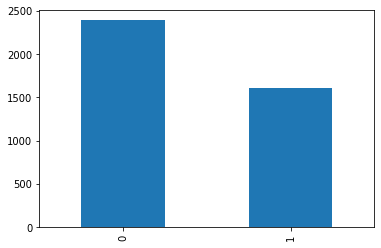

In [77]:
data['label'].value_counts().plot.bar()

In [78]:
data.shape

(3997, 349)

In [79]:
data.drop(['ANTIHIPERTENSIVOS_count','ANTIHIPERTENSIVOS_sum','ANTIHIPERTENSIVOS_mean',\
           'ANTIVERTIGINOSOS_sum','ANTIVERTIGINOSOS_count','ANTIVERTIGINOSOS_mean',\
           'Enfermedad cardíaca hipertensiva','Enfermedad isquémica crónica del corazón',
          'Enfermedad cardíaca hipertensiva sin insuficiencia cardíaca (congestiva)',
          'Enfermedad renal hipertensiva sin insuficiencia renal',
          'Hipertensión secundaria no especificada','Hipertensión secundaria',
          'Enfermedad cardiorrenal hipertensiva','ANTIARRITMICOS_count','ANTIARRITMICOS_sum'], axis=1, inplace=True)

In [80]:
col = list(data.columns)
col

['count_cx_w',
 'years_cx',
 'window',
 'Diabetes mellitus tipo 2',
 'label',
 'Enfermedades del sistema circulatorio',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas otras consecuencias de causas externas',
 'Tumores (neoplasias)',
 'Malformaciones congenitas deformidades y anomalias cromosomica

### Imputaciones

In [81]:
# Imputatio
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(data))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,24.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,4.0


In [82]:
d_inp.shape

(3997, 334)

In [83]:
d_inp.columns = col
d_inp

,count_cx_w,years_cx,window,Diabetes mellitus tipo 2,label,Enfermedades del sistema circulatorio,Enfermedades endocrinas nutricionales y metabolicas,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema nervioso,Factores que influyen en el estado de salud y contacto con los servicios de salud,...,FORMULAS_NUTRICIONALES_COMPLETAS_count,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_sum,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_mean,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_count,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_sum,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_mean,FARMACOS_UTILIZADOS_EN_OSTEOPOROSIS_count,ANTIARRITMICOS_mean,edad_range,imc_range
0,24.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.066464,1.031866,32.675,0.030956,0.465554,29.475,0.015781,30.0,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.000000,0.000000,32.675,0.000000,0.000000,29.475,0.000000,30.0,6.0,4.0


In [84]:
X = d_inp.loc[:, d_inp.columns != 'label']
Y = d_inp[["label"]]

In [85]:
print(X.shape)
print(Y.shape)

(3997, 333)
(3997, 1)


In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=4)

In [87]:
# Parámetros para la mejor selección de variables
grid_param = {
    'n_estimators': [100, 150],
    'min_samples_split': [2, 5, 7, 10,15]
}

#classifier = RandomForestClassifier()
classifier = RandomForestClassifier(oob_score=True, random_state=1234)

#Prepareción del GridSearch
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='precision',
                     cv=2)

In [88]:
#Fit del grid search con r
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(oob_score=True,
                                              random_state=1234),
             param_grid={'min_samples_split': [2, 5, 7, 10, 15],
                         'n_estimators': [100, 150]},
             scoring='precision')

In [89]:
# mejor configuración 
gd_sr.best_estimator_

RandomForestClassifier(min_samples_split=5, n_estimators=150, oob_score=True,
                       random_state=1234)

In [90]:
gd_sr.best_estimator_.n_features_

333

In [91]:
gd_sr.best_estimator_.oob_score_

0.9492313192706471

### Importancia de variables

In [92]:
best_rf = gd_sr.best_estimator_
best_rf.feature_importances_

array([2.96482783e-02, 5.16700380e-03, 4.19929435e-03, 1.55753524e-02,
       1.59908231e-01, 9.25974753e-03, 1.66650230e-03, 8.23057282e-04,
       1.46640468e-03, 1.43612435e-03, 2.02598484e-03, 1.42225862e-03,
       1.63907002e-03, 1.53514788e-03, 1.64979145e-03, 1.12750337e-03,
       1.47020456e-03, 1.49977781e-03, 1.04028352e-03, 1.27872447e-03,
       4.04683429e-04, 7.97870944e-04, 2.02473565e-05, 0.00000000e+00,
       0.00000000e+00, 3.80876376e-04, 4.34311464e-04, 4.12930725e-05,
       7.43415254e-04, 6.83236624e-03, 1.09323666e-04, 3.47788244e-03,
       3.15171678e-04, 7.96477756e-05, 3.80782704e-04, 2.01450592e-05,
       7.21956111e-05, 3.65573655e-04, 2.54590512e-04, 3.61532896e-04,
       0.00000000e+00, 6.54085069e-05, 4.10803218e-04, 4.08693967e-04,
       8.83294311e-06, 0.00000000e+00, 1.07671753e-04, 3.33795825e-05,
       8.53540363e-05, 0.00000000e+00, 0.00000000e+00, 8.70839644e-04,
       0.00000000e+00, 0.00000000e+00, 1.03840429e-04, 2.87179042e-05,
      

In [93]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [94]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [95]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
4,0.159908,Enfermedades del sistema circulatorio
191,0.039507,fn_ta_sistolica_max
199,0.039450,fn_ta_diastolica_count
193,0.037466,fn_ta_sistolica_count
178,0.036899,fn_peso_count
331,0.036221,edad_range
184,0.034150,fn_talla_count
197,0.031054,fn_ta_diastolica_max
0,0.029648,count_cx_w
189,0.029570,fn_ta_sistolica_mean


In [96]:
col_imp = list(importancias[importancias['importance']>0]['feature'])
col_imp.append('label')
col_imp

['Enfermedades del sistema circulatorio',
 'fn_ta_sistolica_max',
 'fn_ta_diastolica_count',
 'fn_ta_sistolica_count',
 'fn_peso_count',
 'edad_range',
 'fn_talla_count',
 'fn_ta_diastolica_max',
 'count_cx_w',
 'fn_ta_sistolica_mean',
 'fn_temperatura_count',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_sum',
 'Trastornos del metabolismo de las lipoproteínas y otras lipidemias',
 'fn_ta_sistolica_median',
 'Diabetes mellitus tipo 2',
 'in_frec_cardiaca_count',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTRICA_count',
 'ANTIDIABÉTICOS_count',
 'fn_ta_sistolica_std',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_sum',
 'in_frec_respiratoria_count',
 'fn_ta_diastolica_mean',
 'Diabetes mellitus tipo 2 sin mención de complicación',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'VITAMÍNICOS_sum',
 'ANTIDIABÉTICOS_sum',
 'Otros trastornos de las venas',
 'ANTIINFLAMATORIOS_NO_ESTEROIDEOS_count',
 'ANTIDIABÉTICOS_mean',
 'fn_peso_max',
 'ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁST

In [97]:
d_fe_f = pd.concat([X, Y])

In [98]:
d_fe_f = d_fe_f[col_imp]
d_fe_f

,Enfermedades del sistema circulatorio,fn_ta_sistolica_max,fn_ta_diastolica_count,fn_ta_sistolica_count,fn_peso_count,edad_range,fn_talla_count,fn_ta_diastolica_max,count_cx_w,fn_ta_sistolica_mean,...,Endocarditis válvula no especificada,Tiroiditis,Bloqueo auriculoventricular y de rama izquierda del haz,Otros trastornos endocrinos,FARMACOS_UTILIZADOS_EN_CÁNCER_DE_MAMA_mean,ANTIANDROGÉNICOS_mean,Otras enfermedades reumáticas del corazón,Otros trastornos metabólicos,Taquicardia paroxística,label
0,0.0,120.0,21.0,21.0,24.0,5.0,24.0,80.0,24.0,112.4,...,0.0,0.0,0.0,0.0,32.675,35.125,0.0,0.0,0.0,NaN
1,0.0,110.0,1.0,1.0,1.0,6.0,1.0,70.0,1.0,110.0,...,0.0,0.0,0.0,0.0,32.675,35.125,0.0,0.0,0.0,NaN
2,1.0,160.0,11.0,12.0,26.0,9.0,26.0,100.0,29.0,131.2,...,0.0,0.0,0.0,0.0,32.675,35.125,0.0,0.0,0.0,NaN
3,1.0,150.0,5.0,6.0,26.0,9.0,26.0,100.0,27.0,140.0,...,0.0,0.0,0.0,0.0,32.675,35.125,0.0,0.0,0.0,NaN
4,1.0,145.0,4.0,4.0,23.0,9.0,23.0,100.0,24.0,136.2,...,0.0,0.0,0.0,0.0,32.675,35.125,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [99]:
# Guardando modelo
import pickle
pickle.dump(gd_sr, open("modelo_ing.pkl", "wb"))

In [100]:
# Guardando Feature Selection
utils.save_df(d_fe_f, "../Data/feature_sel.pkl")

### Importancia de variables usando shap

In [101]:
import xgboost
import shap

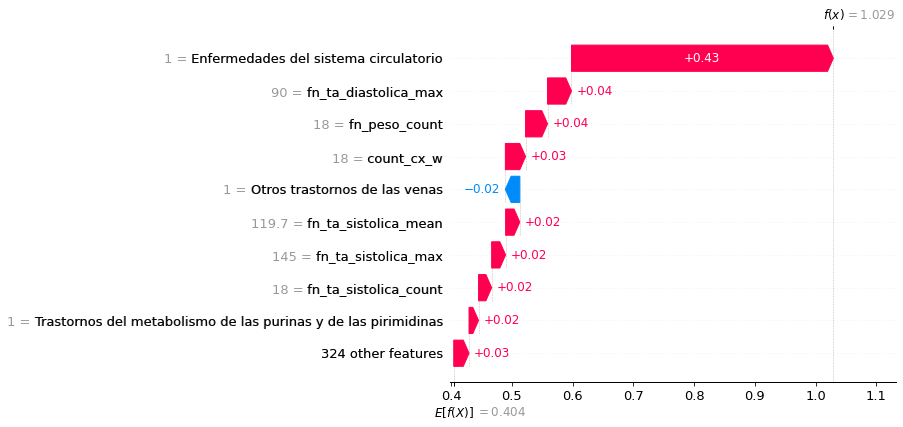

In [102]:
# train an XGBoost model
#X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

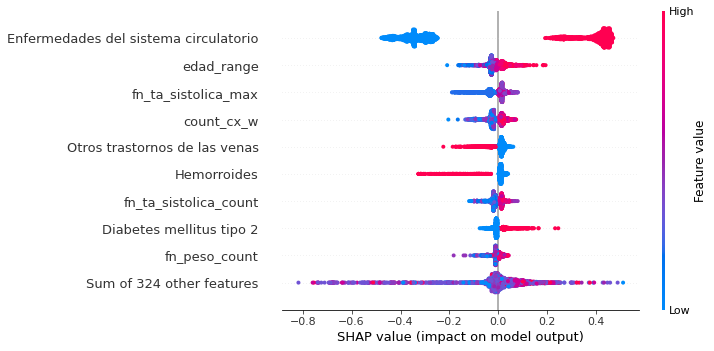

In [103]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

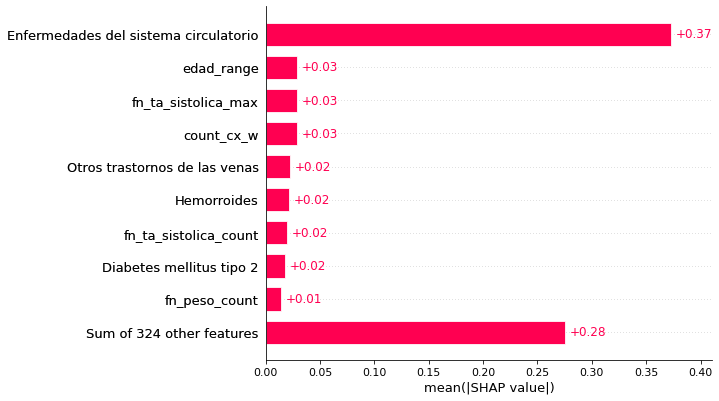

In [104]:
shap.plots.bar(shap_values)